<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Venda_de_A%C3%A7%C3%B5es_Explicado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parada ótima para vender um ativo/opção com preço lognormal — **Versão Explicada** (PT‑BR)

**Modelo de preço diário**

$$
S_n = S_0 \exp\Big( X_1 + \cdots + X_n \Big), \quad X_i \sim \mathcal{N}(\mu,\sigma^2).
$$

Logo, $\log S_n$ é normal e $S_n$ é lognormal.

Defina $\alpha = \mu + \tfrac{\sigma^2}{2}$ (deriva da **média** de $S_n$).
Sem desconto e sem custos:
- Se $\alpha \ge 0$: **esperar até o último dia** maximiza $\mathbb{E}[S_\tau]$.
- Se $\alpha < 0$: **vender agora** maximiza $\mathbb{E}[S_\tau]$.

Mesmo assim, políticas de **alvo/stop** e um método de **parada ótima por regressão** (Longstaff–Schwartz, LSM) podem modificar o **perfil de risco** (ex.: aumentar $\mathbb{P}(\text{lucro}>0)$ ao custo de $\mathbb{E}[\text{lucro}]$).
Este caderno implementa e **explica** cada estratégia.


## Sumário das estratégias implementadas

1. **Vender agora (`sell_now`)** — escolhe $\tau=0$. Maximiza $\mathbb{E}[S_\tau]$ quando $\alpha<0$. É a mais defensiva: elimina a incerteza futura.
2. **Vender no último dia (`sell_last`)** — escolhe $\tau=m$. Maximiza $\mathbb{E}[S_\tau]$ quando $\alpha\ge0$. Aposta na deriva positiva média.
3. **Alvo (take‑profit) (`sell_at_target`)** — define um limiar $T$; vende no primeiro $t$ com $S_t\ge T$ (senão, no dia $m$). Aumenta a chance de **cravar ganhos**; pode reduzir $\mathbb{E}[\text{lucro}]$ se o alvo for muito baixo.
4. **Trailing stop percentual (`sell_trailing_stop`)** — acompanha o máximo $M_t$ e vende quando $S_t\le (1-\rho)M_t$ (senão, em $m$). Tenta **proteger ganhos** com um "pára‑quedas" dinâmico; pode realizar perdas em fases de volatilidade.
5. **Parada ótima Longstaff–Schwartz (`lsm_optimal_stopping`)** — aproxima a decisão ótima em tempo discreto, estimando por regressão o **valor de continuação** $\mathbb{E}[V_{t+1}\mid S_t]$ e comparando com o payoff imediato $S_t-K$. É data‑driven e **adapta** a decisão ao estado $S_t$.


## Parâmetros do experimento
- `S0`: preço inicial; `m`: horizonte (dias).
- `mu`, `sigma`: parâmetros dos incrementos normais $X_i$.
- `K`: preço de compra (lucro = $S-K$).
- `n_paths`: nº de trajetórias Monte Carlo.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def make_rng(seed=None):
    return np.random.default_rng(seed)

def simulate_paths(S0, mu, sigma, m, n_paths, seed=None):
    """
    Gera matriz (m+1, n_paths) com S_t (t=0..m).
    X_i ~ Normal(mu, sigma) independentes.
    """
    rng = make_rng(seed)
    X = rng.normal(mu, sigma, size=(m, n_paths))
    log_S = np.zeros((m+1, n_paths), dtype=float)
    log_S[0,:] = np.log(S0)
    log_S[1:,:] = log_S[0,:] + np.cumsum(X, axis=0)
    return np.exp(log_S)

def alpha_from(mu, sigma):
    return mu + 0.5 * sigma**2


### Estratégia 1 — **Vender agora** (`sell_now`)

- **Regra**: $\tau=0$.
- **Racional**: Se $\alpha<0$, o valor esperado $\mathbb{E}[S_t]$ decresce com o tempo — vender já maximiza $\mathbb{E}[S_\tau]$.
- **Risco**: Perde possíveis altas futuras.


In [ ]:
def sell_now(S, K):
    payoff = S[0,:] - K
    tau = np.zeros(S.shape[1], dtype=int)
    return payoff, tau


### Estratégia 2 — **Vender no último dia** (`sell_last`)

- **Regra**: $\tau=m$.
- **Racional**: Se $\alpha\ge0$, $\mathbb{E}[S_t]$ cresce — esperar maximiza $\mathbb{E}[S_\tau]$.
- **Risco**: Exposta a quedas até o último dia.


In [ ]:
def sell_last(S, K):
    payoff = S[-1,:] - K
    tau = np.full(S.shape[1], S.shape[0]-1, dtype=int)
    return payoff, tau


### Estratégia 3 — **Alvo / Take‑Profit** (`sell_at_target`)

- **Regra**: Vender no primeiro $t$ tal que $S_t \ge T$; se nunca atingir, vender em $m$.
- **Uso típico**: Cristaliza lucros quando o preço chega a um **alvo** planejado; reduz risco de "devolver" ganhos.
- **Trade‑off**: Alvos baixos aumentam $\mathbb{P}(\text{lucro}>0)$, mas tendem a reduzir $\mathbb{E}[\text{lucro}]$.


In [ ]:
def sell_at_target(S, K, T):
    m1, n = S.shape
    m = m1 - 1
    tau = np.full(n, m, dtype=int)
    payoff = S[-1,:] - K
    for j in range(n):
        hit = np.where(S[:,j] >= T)[0]
        if hit.size > 0:
            t = hit[0]
            tau[j] = t
            payoff[j] = S[t,j] - K
    return payoff, tau


### Estratégia 4 — **Trailing Stop** (`sell_trailing_stop`)

- **Regra**: Atualiza o máximo $M_t = \max_{s\le t} S_s$. Vende quando $S_t \le (1-\rho) M_t$ (queda de $\rho\times 100\%$ do pico), ou no último dia.
- **Uso típico**: **Proteção de ganhos** com um "pára‑quedas" dinâmico frente a reversões.
- **Trade‑off**: Pode "stopar" durante ruído; escolher $\rho$ é crucial (muito pequeno = realiza cedo; muito grande = pouca proteção).


In [ ]:
def sell_trailing_stop(S, K, rho=0.1):
    m1, n = S.shape
    m = m1 - 1
    tau = np.full(n, m, dtype=int)
    payoff = S[-1,:] - K
    for j in range(n):
        M = S[0,j]
        sold = False
        for t in range(1, m+1):
            M = max(M, S[t,j])
            if S[t,j] <= (1 - rho) * M:
                tau[j] = t
                payoff[j] = S[t,j] - K
                sold = True
                break
        if not sold:
            tau[j] = m
            payoff[j] = S[m,j] - K
    return payoff, tau


### Estratégia 5 — **Parada ótima por Longstaff–Schwartz** (`lsm_optimal_stopping`)

Queremos aproximar:
\[ V_t(S_t) = \max\{ S_t - K,\; \mathbb{E}[V_{t+1}(S_{t+1})\mid S_t] \}. \]

O algoritmo LSM (Longstaff–Schwartz, 2001) usa **regressão** para estimar o valor de continuação a partir de trajetórias simuladas:

1. **Simular** muitas trajetórias de $S$.
2. **Retroceder** do penúltimo dia $t=m-1$ até $0$.
3. Em cada $t$, sobre os caminhos **in‑the‑money** ($S_t-K>0$), ajustar uma regressão dos **fluxos futuros** observados (quando não exercidos antes) em uma **base de funções** de $S_t$, ex.: $1, S_t, S_t^2, \log S_t$.
4. **Exercer** quando o payoff imediato $S_t-K$ exceder o valor de continuação estimado.


In [ ]:
def lsm_optimal_stopping(S, K, basis="logpoly", degree=2):
    """
    Longstaff-Schwartz (sem desconto) para payoff S_t - K.
    S: matriz (m+1, n_paths)
    Retorna (payoff, tau) com a política aproximada.
    """
    m1, n = S.shape
    m = m1 - 1
    tau = np.full(n, m, dtype=int)
    cash = S[m,:] - K  # valor se vender no fim
    for t in range(m-1, -1, -1):
        St = S[t,:]
        itm = (St - K) > 0
        idx = np.where(itm)[0]
        if idx.size > 0:
            X = St[idx]
            Y = cash[idx]  # valor futuro sob a política corrente
            # base de regressão
            if basis == "poly":
                Phi = np.vstack([np.ones_like(X), X, X**2][:degree+1]).T
            else:
                LX = np.log(np.maximum(X, 1e-12))
                Phi = np.vstack([np.ones_like(X), X, X**2, LX]).T
            coef, *_ = np.linalg.lstsq(Phi, Y, rcond=None)
            # continuação estimada para todos
            if basis == "poly":
                Phi_all = np.vstack([np.ones_like(St), St, St**2][:degree+1]).T
            else:
                LX_all = np.log(np.maximum(St, 1e-12))
                Phi_all = np.vstack([np.ones_like(St), St, St**2, LX_all]).T
            cont = Phi_all @ coef
        else:
            cont = np.zeros(n)
        imm = St - K
        ex_now = imm > cont
        tau[ex_now] = t
        cash[ex_now] = imm[ex_now]
    return cash, tau


## Experimento base (edite os parâmetros abaixo)

> **Dica didática**: explore ambos os regimes — um com $\alpha<0$ (deriva negativa) e outro com $\alpha\ge0$ — e compare as políticas.


In [15]:
# Parâmetros do cenário
S0 = 100.0
mu = -0.02     # média do incremento em log
sigma = 0.2    # desvio do incremento (exemplo didático)
m = 30         # horizonte (dias)
K = 100.0      # preço de compra
n_paths = 20000
seed = 2026

alpha = alpha_from(mu, sigma)
print("alpha =", alpha, "(>=0 => esperar até m; <0 => vender agora maximize E[S_tau])")

# Simulação de trajetórias
S = simulate_paths(S0, mu, sigma, m, n_paths, seed=seed)

# Avaliação de políticas
p_now, t_now = sell_now(S, K)
p_last, t_last = sell_last(S, K)
p_target, t_target = sell_at_target(S, K, T=110.0)
p_trail, t_trail = sell_trailing_stop(S, K, rho=0.1)
p_lsm, t_lsm = lsm_optimal_stopping(S, K, basis="logpoly")


alpha = 3.469446951953614e-18 (>=0 => esperar até m; <0 => vender agora maximize E[S_tau])


In [16]:
def summary(name, payoff, tau):
    return f"{name:>16s} | E[payoff]={payoff.mean():.4f} | mediana τ={int(np.median(tau))} | P(lucro>0)={(payoff>0).mean():.3f}"

print(summary("sell_now", p_now, t_now))
print(summary("sell_last", p_last, t_last))
print(summary("target@110", p_target, t_target))
print(summary("trail 10%", p_trail, t_trail))
print(summary("LSM", p_lsm, t_lsm))


        sell_now | E[payoff]=0.0000 | mediana τ=0 | P(lucro>0)=1.000
       sell_last | E[payoff]=-0.4975 | mediana τ=30 | P(lucro>0)=0.293
      target@110 | E[payoff]=0.4310 | mediana τ=4 | P(lucro>0)=0.743
       trail 10% | E[payoff]=-0.2489 | mediana τ=2 | P(lucro>0)=0.298
             LSM | E[payoff]=0.7722 | mediana τ=2 | P(lucro>0)=0.417


## Visualizações
- **Distribuição do dia de venda** por política.
- **Trajetórias amostrais** com a **decisão LSM** marcada.


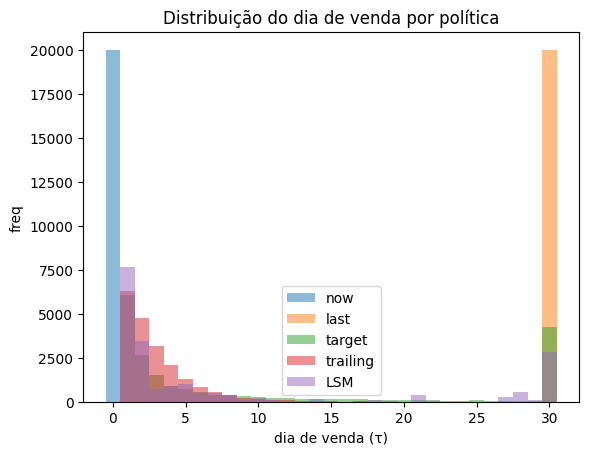

In [ ]:
# Histogramas dos dias de venda
fig, ax = plt.subplots()
bins = np.arange(0, m+2) - 0.5
ax.hist(t_now, bins=bins, alpha=0.5, label="now")
ax.hist(t_last, bins=bins, alpha=0.5, label="last")
ax.hist(t_target, bins=bins, alpha=0.5, label="target")
ax.hist(t_trail, bins=bins, alpha=0.5, label="trailing")
ax.hist(t_lsm, bins=bins, alpha=0.5, label="LSM")
ax.set_xlabel("dia de venda (τ)"); ax.set_ylabel("freq")
ax.set_title("Distribuição do dia de venda por política")
ax.legend()
plt.show()


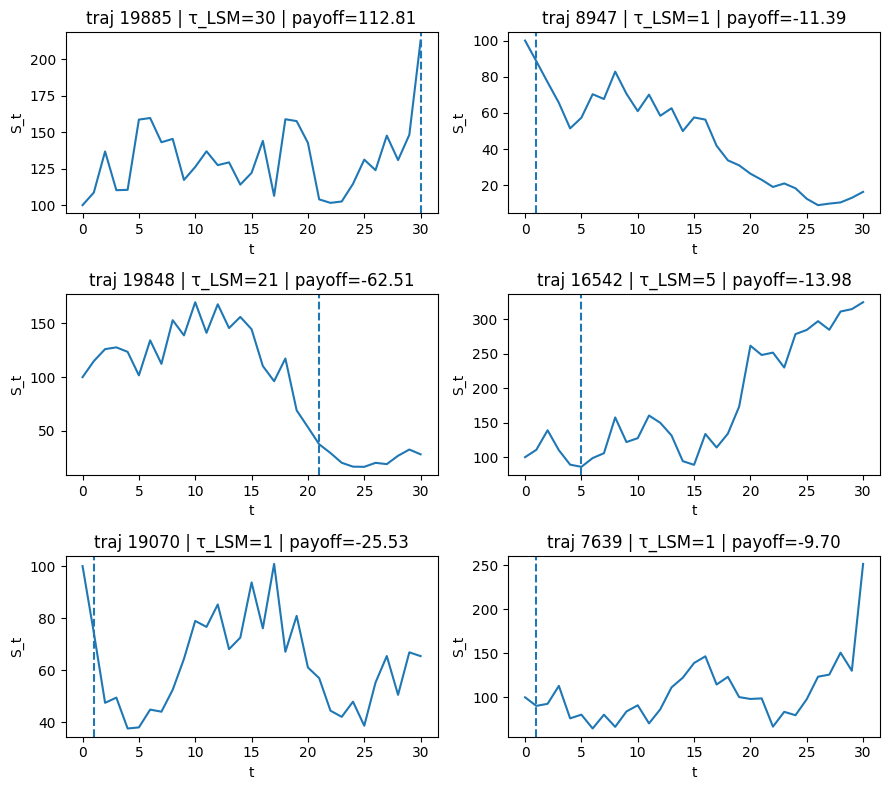

In [12]:
# Algumas trajetórias com τ_LSM destacado
rng = make_rng(2025)
idx = rng.choice(S.shape[1], size=6, replace=False)
fig, axes = plt.subplots(3,2, figsize=(9,8))
axes = axes.ravel()
for k,i in enumerate(idx):
    axes[k].plot(S[:,i])
    axes[k].axvline(t_lsm[i], linestyle="--")
    axes[k].set_title(f"traj {i} | τ_LSM={t_lsm[i]} | payoff={p_lsm[i]:.2f}")
    axes[k].set_xlabel("t"); axes[k].set_ylabel("S_t")
plt.tight_layout()
plt.show()


## Extensões sugeridas

1. **Desconto temporal**: maximizar $\mathbb{E}[ e^{-rt} (S_t-K) ]$ com taxa $r$; impacta a "preferência" por vender cedo/tarde.
2. **Custos de transação**: subtrair um custo fixo ou proporcional no lucro ao vender.
3. **Aversão a risco**: maximizar $\mathbb{E}[u(S_\tau-K)]$ (ex.: utilidade CARA/CRRA) em vez do valor esperado.
4. **Otimização de alvo/stop**: buscar $T$ e $\rho$ que maximizem um critério (ex.: média sujeita a VaR/ES).
5. **Janela de exercício**: restringir $\tau$ a um subconjunto de dias (american‑style em janelas).
